In [1]:
! pip install kaggle
! pip install contractions
! pip install langdetect
! pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=6766b326ab0f52422dc0c363999aad89cdd0444747e055b550ffa271f98aad24
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Download data from fake news competition**

In [3]:
from google.colab import files

# select your kaggle API token
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
! kaggle competitions download -c 'fake-news'
!ls

 99% 46.0M/46.5M [00:03<00:00, 15.0MB/s]
100% 46.5M/46.5M [00:03<00:00, 13.1MB/s]
drive  fake-news.zip  kaggle.json  sample_data


In [5]:
import zipfile
import pandas as pd

with zipfile.ZipFile('fake-news.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(20800, 5)
(5200, 4)


# **Data Preprocessing**

In [7]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
# Verify null fields
train[train.text.isna()].head(5)

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1


## Null values treatment

In [10]:
# Train dataset
train["author"] = train["author"].fillna("")
train["title"] = train["title"].fillna("")
train["text"] = train["text"].fillna("")
print('Train sum null values: ',train.isna().sum().sum())

# Test dataset
test["author"] = test["author"].fillna("")
test["title"] = test["title"].fillna("")
test["text"] = test["text"].fillna("")
print('Train sum null values: ', test.isna().sum().sum())

Train sum null values:  0
Train sum null values:  0


In [11]:
# create new field input to model
train["input_text"] = train["author"] + ' ' + train["title"] + ' ' + train["text"]
test["input_text"] = test["author"] + ' ' + test["title"] + ' ' + test["text"]

In [12]:
train.head()

,id,title,author,text,label,input_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


## Data Analysis

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

([<matplotlib.patches.Wedge at 0x78b41276b8e0>,
 [Text(-1.149997783093558, -0.0022580699507423834, 'Fake'),
  Text(1.149997783093558, 0.002258069950741731, 'True')],
 [Text(-0.649998746965924, -0.0012763004069413467, '50.1%'),
  Text(0.649998746965924, 0.0012763004069409785, '49.9%')])

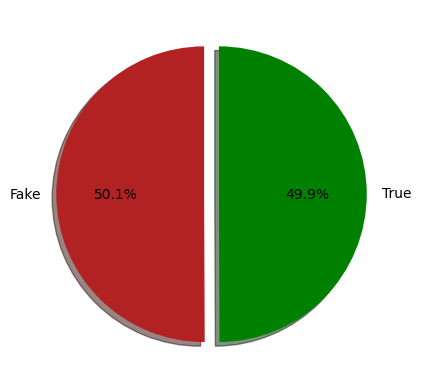

In [ ]:
# Data balanced

label_size = [train['label'].sum(),len(train['label'])-train['label'].sum()]
plt.pie(label_size,explode=[0.05,0.05],colors=['firebrick','green'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [13]:
from langdetect import detect

news_lang_detected = train["input_text"].apply(detect)
news_lang_detected_test = test["input_text"].apply(detect)

In [14]:
df_news_lang_detected = pd.DataFrame({"lang" : news_lang_detected, "label": train["label"]})
df_news_lang_detected.value_counts()

lang   label
en     0        10386
       1         9879
ru     1          156
es     1          141
de     1           95
fr     1           70
ar     1           19
no     1            8
pt     1            7
tr     1            7
nl     1            6
it     1            5
hr     1            3
af     1            2
ca     1            2
cy     1            2
da     1            2
el     1            2
sv     1            2
id     1            1
fr     0            1
so     1            1
pl     1            1
sw     1            1
zh-cn  1            1
Name: count, dtype: int64

In [15]:
news_lang_detected_test.value_counts()

input_text
en    5059
ru      47
es      32
de      25
fr      15
it       5
pt       4
ar       3
id       3
tr       3
el       2
no       1
tl       1
Name: count, dtype: int64

In [16]:
# Token length

from typing import Dict, List

def get_token_counts(dataset: pd.DataFrame) -> Dict:
    token_counts = {"test": []}
    for _, row in dataset.iterrows():
        token_count = len(row["input_text"].split(" "))
        # print(token_count)
        if "label" in list(dataset.columns):
            # print(list(dataset.columns))
            if row["label"] not in token_counts:
                token_counts[row["label"]] = [token_count]
                # print('token counts if', token_counts)
            else:
                token_counts[row["label"]].append(token_count)
                # print('token counts else', token_counts)
        else:
            token_counts["test"].append(token_count)
    return token_counts

In [17]:
train_num_tokens = get_token_counts(train.copy())
test_num_tokens = get_token_counts(test.copy())

In [18]:
print(train_num_tokens.keys())
print(test_num_tokens.keys())
df_train_num_tokens = pd.concat([pd.DataFrame({"label": 0, "token_length": train_num_tokens[0]}), pd.DataFrame({"label": 1, "token_length": train_num_tokens[1]})])
df_train_num_tokens.head()

dict_keys(['test', 1, 0])
dict_keys(['test'])


,label,token_length
0,0,739
1,0,228
2,0,865
3,0,1472
4,0,1794


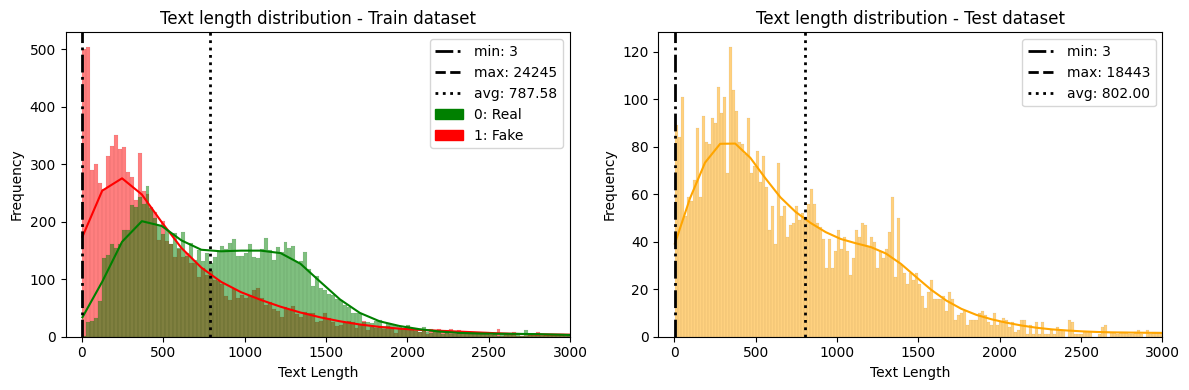

In [21]:
import matplotlib.patches as mpatches

train_avg_length = sum(df_train_num_tokens["token_length"]) / len(df_train_num_tokens["token_length"])
train_max_length = max(df_train_num_tokens["token_length"])
train_min_length = min(df_train_num_tokens["token_length"])

test_avg_length = int(sum(test_num_tokens["test"]) / len(test_num_tokens["test"]))
test_max_length = max(test_num_tokens["test"])
test_min_length = min(test_num_tokens["test"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

colors_label = {0: "green", 1: "red"}
patch_label_0 = mpatches.Patch(color="green", label="0: Real")
patch_label_1 = mpatches.Patch(color="red", label="1: Fake")

sns.histplot(data = df_train_num_tokens, x = "token_length", kde=True, bins=1000, ax=axes[0], hue = "label", palette=colors_label)
axes[0].axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
axes[0].axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
axes[0].axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.2f}')
axes[0].set_title("Text length distribution - Train dataset")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 3000)
handles, labels = axes[0].get_legend_handles_labels()
handles.extend([patch_label_0, patch_label_1])
axes[0].legend(handles=handles)

sns.histplot(test_num_tokens["test"], kde=True, color="orange", bins=1000, ax=axes[1])
axes[1].axvline(test_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {test_min_length}')
axes[1].axvline(test_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {test_max_length}')
axes[1].axvline(test_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {test_avg_length:.2f}')
axes[1].set_title("Text length distribution - Test dataset")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(-100, 3000)
axes[1].legend()

plt.tight_layout()
plt.show()

In [22]:
stats_label_0 = df_train_num_tokens.query("label == 0").describe()
stats_label_1 = df_train_num_tokens.query("label == 1").describe()

pd.concat([stats_label_0, stats_label_1], axis=1)

,label,token_length,label,token_length
count,10387.0,10387.000000,10413.0,10413.000000
mean,0.0,923.974295,1.0,651.528762
std,0.0,766.173310,0.0,965.746526
min,0.0,13.000000,1.0,3.000000
25%,0.0,431.000000,1.0,185.000000
50%,0.0,816.000000,1.0,397.000000
75%,0.0,1234.000000,1.0,803.000000
max,0.0,15283.000000,1.0,24245.000000


In [23]:
from nltk.probability import FreqDist
train_df_words = pd.DataFrame({"input_text": train["input_text"], "label": train["label"]})
tokens_label_0 = [token for i, lista_tokens in enumerate(train_df_words['input_text'])
                  if train_df_words['label'].iloc[i] == 0 for token in list(lista_tokens.split(" "))]
tokens_label_1 = [token for i, lista_tokens in enumerate(train_df_words['input_text'])
                  if train_df_words['label'].iloc[i] == 1 for token in list(lista_tokens.split(" "))]

In [24]:
fdist_label_0 = FreqDist(tokens_label_0)
fdist_label_1 = FreqDist(tokens_label_1)

In [25]:
print("Most frequent words real news:")
fdist_label_0.most_common(10)

Most frequent words real news:


[('the', 477786),
 ('', 297406),
 ('to', 245507),
 ('of', 238936),
 ('a', 221848),
 ('and', 206978),
 ('in', 173291),
 ('that', 114656),
 ('for', 82760),
 ('on', 77853)]

In [26]:
print("Most frequent words fake news:")
fdist_label_1.most_common(10)

Most frequent words fake news:


[('the', 338838),
 ('of', 178441),
 ('to', 177388),
 ('and', 157253),
 ('a', 123307),
 ('in', 108568),
 ('that', 81339),
 ('is', 78508),
 ('for', 54773),
 ('on', 45013)]

## Cleaning data

In [27]:
# Split train dataset (train, val, test)

original_train = train.copy()
train = train[["input_text", "label"]]

train_size = int(0.9 * len(train))
train_df = train[:train_size]
test_df = train[train_size:]

In [28]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_df['input_text'], train_df['label'],
                                                                    random_state=1108,
                                                                    test_size=0.3,
                                                                    shuffle=False)
val_label = val_label.reset_index()["label"]
test_data, test_label = test_df['input_text'], test_df['label']
test_data_submission = test['input_text']

print('Train dataset: ', train_data.shape)
print('Validation dataset: ', val_data.shape)
print('Test dataset: ', test_data.shape)
print('Test dataset submission Kaggle: ', test_data_submission.shape)

Train dataset:  (13104,)
Validation dataset:  (5616,)
Test dataset:  (2080,)
Test dataset submission Kaggle:  (5200,)


In [ ]:
import nltk
import re

import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lowercasing_text(input_text):
    input_text = input_text.apply(lambda x: x.lower())
    return input_text

def words_contractions_processing(input_text):
    try:
        input_text = input_text.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    except:
        None
    return input_text

def remove_numeric_values(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'\d+', ' ', x))
    return input_text

def remove_punctuation(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    return input_text

def remove_line_break(input_text):
    input_text = input_text.apply(lambda x: x.replace("\n", " "))
    return input_text

def english_vocabulary(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'[^a-z]+', ' ', x))
    return input_text

def remove_spaces_between_words(input_text):
    input_text = input_text.apply(lambda x: re.sub(r'\s+', ' ', x))
    return input_text

# Lemmatization functions
def nltkToWordnet(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatize a list of words/tokens
def lemmatize(tokens):
    pos_tags = nltk.pos_tag(tokens)
    res_words = []
    for word, tag in pos_tags:
        tag = nltkToWordnet(tag)
        if tag is None:
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return res_words

def lemmatization_stopwords_removal(input_text):
    input_text = input_text.apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    input_text = input_text.apply(lambda x: lemmatize(x))
    input_text =  input_text.apply(lambda x: [word for word in x if word not in stop_words])
    input_text = input_text.apply(" ".join)
    return input_text

In [ ]:
def preprocessing_news(data):
    data = lowercasing_text(data)
    data = words_contractions_processing(data)
    data = remove_numeric_values(data)
    data = remove_punctuation(data)
    data = remove_line_break(data)
    data = english_vocabulary(data)
    data = remove_spaces_between_words(data)
    data = lemmatization_stopwords_removal(data)
    return data

In [ ]:
import datetime

ini = datetime.datetime.now()
train_data = preprocessing_news(train_data)
val_data = preprocessing_news(val_data)
test_data = preprocessing_news(test_data)
test_data_submission = preprocessing_news(test_data_submission)
end = datetime.datetime.now()

print('Duration cleaning data: ' , end-ini)

Duration cleaning data:  0:14:28.690230


In [30]:
df_train_clean = pd.DataFrame({"input_text": train_data, "label": train_label})
train_clean_num_tokens = get_token_counts(df_train_clean)

train_clean_avg_length = (sum(train_clean_num_tokens[1]) + sum(train_clean_num_tokens[0]))/(len(train_clean_num_tokens[1]) + len(train_clean_num_tokens[0]))
train_clean_max_length = max(max(train_clean_num_tokens[1]),max(train_clean_num_tokens[1]))
train_clean_min_length = min(min(train_clean_num_tokens[1]),min(train_clean_num_tokens[1]))

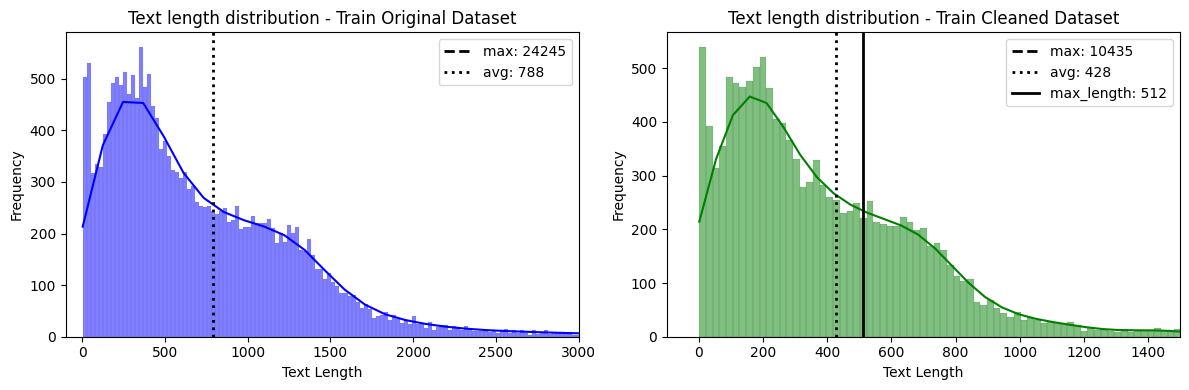

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data = df_train_num_tokens, x = "token_length", kde=True, color="blue", bins=1000, ax=axes[0])
# axes[0].axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
axes[0].axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
axes[0].axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.0f}')
axes[0].set_title("Text length distribution - Train Original Dataset")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 3000)
axes[0].legend()

sns.histplot(train_clean_num_tokens[0]+train_clean_num_tokens[1], kde=True, color="green", bins=500, ax=axes[1])
# axes[1].axvline(train_clean_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_clean_min_length}')
axes[1].axvline(train_clean_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_clean_max_length}')
axes[1].axvline(train_clean_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_clean_avg_length:.0f}')
axes[1].axvline(512, color='black', linewidth=2, label=f'max_length: {512:.0f}')
axes[1].set_title("Text length distribution - Train Cleaned Dataset")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(-100, 1500)
axes[1].legend()

plt.tight_layout()
plt.show()

In [32]:
df_train_clean_num_tokens = pd.concat([pd.DataFrame({"label": 0, "token_length": train_clean_num_tokens[0]}), pd.DataFrame({"label": 1, "token_length": train_clean_num_tokens[1]})])

stats_train_original = df_train_num_tokens.describe()
stats_train_clean = df_train_clean_num_tokens.describe()

df_concat_stats = pd.concat([stats_train_original, stats_train_clean], axis=1)
df_concat_stats.columns = [["label1","token_length_train_original","label2", "token_length_train_cleaned"]]

In [33]:
df_concat_stats[["token_length_train_original", "token_length_train_cleaned"]]

,token_length_train_original,token_length_train_cleaned
count,20800.000000,13104.000000
mean,787.581250,427.825092
std,882.372346,467.283184
min,3.000000,1.000000
25%,286.000000,157.000000
50%,580.000000,318.500000
75%,1086.000000,588.250000
max,24245.000000,10435.000000


In [34]:
train_data_words = pd.DataFrame({"input_text": train_data, "label": train_label})

In [35]:
train_tokens_label_0 = [token for i, lista_tokens in enumerate(train_data_words['input_text'])
                  if train_data_words['label'].iloc[i] == 0 for token in list(lista_tokens.split(" "))]
train_tokens_label_1 = [token for i, lista_tokens in enumerate(train_data_words['input_text'])
                  if train_data_words['label'].iloc[i] == 1 for token in list(lista_tokens.split(" "))]

In [36]:
fdist_label_0 = FreqDist(train_tokens_label_0)
fdist_label_1 = FreqDist(train_tokens_label_1)

In [37]:
print("Most frequent words real news:")
fdist_label_0.most_common(10)

Most frequent words real news:


[('say', 52278),
 ('mr', 41817),
 ('trump', 23268),
 ('new', 16737),
 ('would', 15957),
 ('state', 15655),
 ('time', 15336),
 ('one', 14945),
 ('year', 13784),
 ('people', 12886)]

In [38]:
print("Most frequent words fake news:")
fdist_label_1.most_common(10)

Most frequent words fake news:


[('clinton', 13154),
 ('say', 13151),
 ('trump', 12764),
 ('people', 10889),
 ('would', 10616),
 ('one', 10536),
 ('state', 10465),
 ('us', 9879),
 ('hillary', 8391),
 ('go', 8298)]

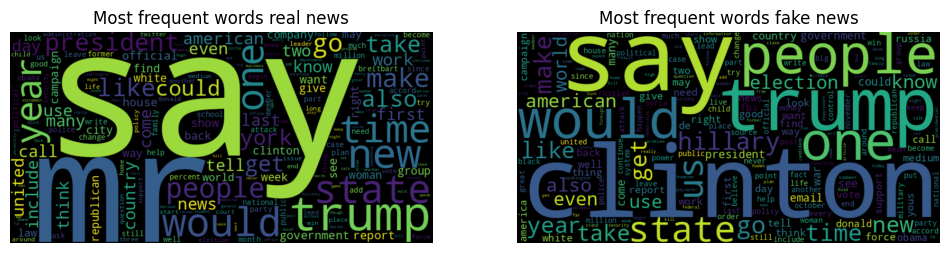

In [39]:
from wordcloud import WordCloud

wordcloud_label_0 = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(fdist_label_0)
wordcloud_label_1 = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(fdist_label_1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('Most frequent words real news')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('Most frequent words fake news')
plt.axis('off')

plt.show()

In [40]:
import numpy as np

data_array = np.array(train_clean_num_tokens[0] + train_clean_num_tokens[1])
limit_tokens = np.sum(data_array <= 512)
print(f"{(limit_tokens / len(data_array))*100:.0f}% of the news have less than or equal to 512 tokens")

69% of the news have less than or equal to 512 tokens


# **DistilBERT Model Using Pytorch Trainer**

In [ ]:
max_length = 512
transformer_model = "distilbert/distilbert-base-uncased"

## Preparing input data

In [ ]:
from datasets import Dataset, DatasetDict

# Convert pandas Dataframe to Dataset (to be accepted by pytorch trainer)

train_dataset = Dataset.from_dict({
    "input_ids": train_data,
    "labels": train_label
})

val_dataset = Dataset.from_dict({
    "input_ids": val_data,
    "labels": val_label
})

In [ ]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 13104
})
Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 5616
})


In [ ]:
print(train_dataset[0].keys())
train_dataset.shape

dict_keys(['input_ids', 'labels'])


(13104, 2)

## Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(transformer_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["input_ids"], max_length = max_length, truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function,batched=True)
tokenized_val = val_dataset.map(preprocess_function,batched=True)

Map:   0%|          | 0/13104 [00:00<?, ? examples/s]

Map:   0%|          | 0/5616 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 13104
})

In [ ]:
print(tokenized_train[0])
print(tokenized_train[0].keys())

{'input_ids': [101, 23158, 12776, 2271, 2160, 17183, 14895, 2130, 2156, 2272, 7274, 3661, 4463, 15775, 16020, 5753, 1056, 28394, 2102, 2160, 17183, 14895, 2130, 2156, 2272, 7274, 3661, 4463, 15775, 16020, 5753, 1056, 28394, 2102, 23158, 12776, 2271, 2255, 4942, 29234, 4463, 15775, 16020, 5753, 22475, 2137, 9292, 6646, 3746, 14571, 2745, 8183, 25105, 2800, 5541, 7674, 3762, 6105, 12480, 6766, 19330, 23991, 2078, 4797, 2919, 2711, 2088, 2733, 26337, 2072, 2472, 2508, 2272, 2100, 15802, 2160, 3537, 14895, 2298, 2066, 2036, 2113, 2117, 12155, 12096, 2711, 2092, 2735, 2272, 2100, 4604, 2085, 2378, 7011, 27711, 3661, 14970, 8495, 2298, 10373, 2089, 14396, 18520, 7207, 10373, 8241, 5464, 7672, 7882, 2837, 2963, 2272, 2100, 2424, 3081, 1056, 28394, 2102, 2028, 3951, 2837, 3472, 2113, 2272, 2100, 2025, 8757, 3951, 3472, 3537, 4635, 2266, 2160, 4454, 14814, 15709, 2837, 4034, 3319, 10373, 3728, 7523, 2344, 2156, 5383, 26268, 2592, 2146, 3661, 2175, 15709, 2837, 3472, 4463, 15775, 16020, 5753, 22

## Training

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "Real", 1: "Fake"}
label2id = {"Real": 0, "Fake": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    transformer_model,
    num_labels=2,
    id2label=id2label,
    label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/TFM/distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.158000,0.048321,0.989494
2,0.027300,0.052537,0.990563
3,0.005800,0.042552,0.993234


TrainOutput(global_step=2457, training_loss=0.047222260008219254, metrics={'train_runtime': 1202.0227, 'train_samples_per_second': 32.705, 'train_steps_per_second': 2.044, 'total_flos': 5207488002659136.0, 'train_loss': 0.047222260008219254, 'epoch': 3.0})

## Evaluation

In [ ]:
trainer.evaluate()

{'eval_loss': 0.042551979422569275,
 'eval_accuracy': 0.9932336182336182,
 'eval_runtime': 53.7948,
 'eval_samples_per_second': 104.397,
 'eval_steps_per_second': 6.525,
 'epoch': 3.0}

In [ ]:
trainer.state.log_history

[{'loss': 0.158,
  'grad_norm': 4.488610744476318,
  'learning_rate': 1.5929995929995933e-05,
  'epoch': 0.6105006105006106,
  'step': 500},
 {'eval_loss': 0.0483209453523159,
  'eval_accuracy': 0.989494301994302,
  'eval_runtime': 53.2185,
  'eval_samples_per_second': 105.527,
  'eval_steps_per_second': 6.595,
  'epoch': 1.0,
  'step': 819},
 {'loss': 0.0351,
  'grad_norm': 0.01996566914021969,
  'learning_rate': 1.1859991859991862e-05,
  'epoch': 1.221001221001221,
  'step': 1000},
 {'loss': 0.0273,
  'grad_norm': 0.006629243027418852,
  'learning_rate': 7.78998778998779e-06,
  'epoch': 1.8315018315018317,
  'step': 1500},
 {'eval_loss': 0.0525367297232151,
  'eval_accuracy': 0.9905626780626781,
  'eval_runtime': 53.2442,
  'eval_samples_per_second': 105.476,
  'eval_steps_per_second': 6.592,
  'epoch': 2.0,
  'step': 1638},
 {'loss': 0.0058,
  'grad_norm': 0.03481411188840866,
  'learning_rate': 3.7199837199837202e-06,
  'epoch': 2.442002442002442,
  'step': 2000},
 {'eval_loss': 0.

In [ ]:
history = pd.DataFrame(trainer.state.log_history).dropna(subset=["eval_loss"]).set_index("epoch")
history

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,819,0.048321,0.989494,53.2185,105.527,6.595,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,1638,0.052537,0.990563,53.2442,105.476,6.592,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,2457,0.042552,0.993234,53.2397,105.485,6.593,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,2457,0.042552,0.993234,53.7948,104.397,6.525,NaN,NaN,NaN,NaN,NaN


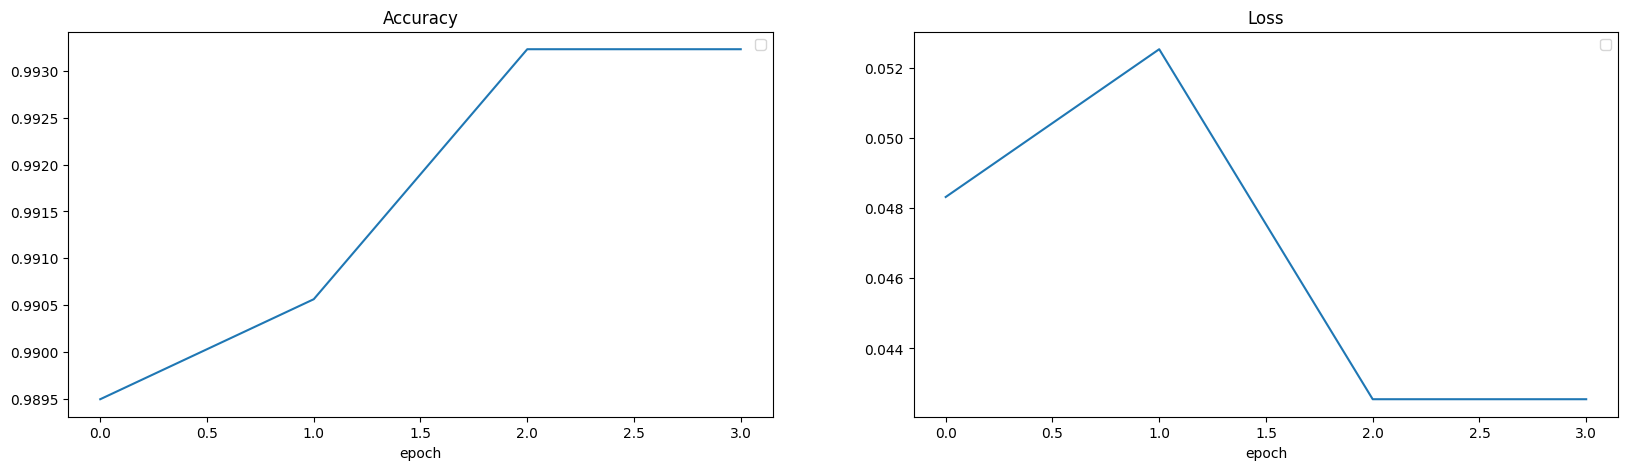

In [ ]:
histories = {
    "Accuracy": history['eval_accuracy'].values,
    "Loss": history['eval_loss'].values
}

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, metric in enumerate(["Accuracy", "Loss"]):
    ax[i].plot(histories[metric])
    ax[i].set_title(metric)
    ax[i].set_xlabel("epoch")
    ax[i].legend()

plt.show()

## Prediction

### Test Dataset

In [ ]:
tokenized_test = tokenizer(test_data.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

test_dataset = Dataset.from_dict(
    {"input_ids": tokenized_test["input_ids"],
     "attention_mask": tokenized_test["attention_mask"]}
    )


In [ ]:
print(test_dataset[0])

{'input_ids': [101, 10812, 7564, 6947, 3698, 19838, 1059, 16066, 2036, 2812, 19817, 5369, 8554, 19838, 2674, 3698, 2442, 2113, 3198, 8554, 4595, 3198, 3160, 5724, 2825, 2425, 3634, 2454, 2111, 8554, 2228, 5263, 2307, 9530, 7069, 2224, 2627, 3449, 20624, 2239, 2765, 19838, 4903, 5596, 2594, 2102, 2925, 2765, 2036, 8040, 3286, 2061, 7352, 5987, 22035, 19270, 14540, 5178, 2759, 3789, 3377, 28940, 4140, 8398, 2343, 7207, 22035, 2102, 5280, 2063, 3066, 28940, 4140, 5717, 17834, 3066, 10303, 15544, 23500, 3070, 15453, 5091, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
predictions

PredictionOutput(predictions=array([[-4.833501 ,  4.2427716],
       [ 5.0411363, -4.4196944],
       [-4.7171364,  4.1231313],
       ...,
       [ 5.023612 , -4.420227 ],
       [-4.735497 ,  4.1829257],
       [-4.6342177,  4.0875554]], dtype=float32), label_ids=None, metrics={'test_runtime': 18.2293, 'test_samples_per_second': 114.102, 'test_steps_per_second': 7.131})

In [ ]:
preds = predictions.predictions.argmax(-1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

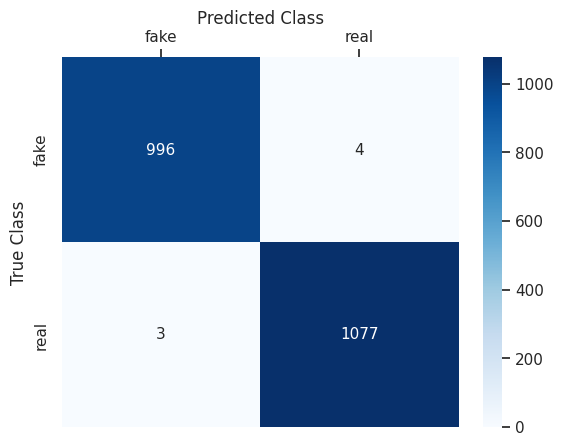

              precision    recall  f1-score   support

        fake     0.9970    0.9960    0.9965      1000
        real     0.9963    0.9972    0.9968      1080

    accuracy                         0.9966      2080
   macro avg     0.9966    0.9966    0.9966      2080
weighted avg     0.9966    0.9966    0.9966      2080



In [ ]:
confusion = confusion_matrix(np.array(test_label), preds)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["fake", "real"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(np.array(test_label), preds, digits = 4, output_dict=False, target_names=["fake", "real"],)
print(report)

### Test Dataset Kaggle (Submission)

In [ ]:
tokenized_test_sub = tokenizer(test_data_submission.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

test_dataset_sub = Dataset.from_dict(
    {"input_ids": tokenized_test_sub["input_ids"],
     "attention_mask": tokenized_test_sub["attention_mask"]}
    )

In [ ]:
test["id"]

0       20800
1       20801
2       20802
3       20803
4       20804
        ...  
5195    25995
5196    25996
5197    25997
5198    25998
5199    25999
Name: id, Length: 5200, dtype: int64

In [ ]:
print(test_dataset_sub.shape)

(5200, 2)


In [ ]:
predictions_sub = trainer.predict(test_dataset_sub)

In [ ]:
preds_sub = predictions_sub.predictions.argmax(-1)

In [ ]:
kaggle_results = pd.DataFrame({"id":test["id"], "label": preds_sub})
kaggle_results.to_csv("/content/drive/MyDrive/Colab Notebooks/TFM/distilbert.csv", index=False)

## Save Model

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/TFM/distilbert_model")

In [ ]:
model_loaded = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/TFM/distilbert_model")

In [ ]:
model_loaded

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
text_news = """
Trump taps federal appeals court Judge Brett Kavanaugh for Supreme Court
WASHINGTON — President Donald Trump on Monday nominated Brett Kavanaugh, a federal appeals court judge in Washington, to succeed Justice Anthony Kennedy on the Supreme Court.
Trump made the announcement shortly after 9 p.m. ET at the White House, where he was joined by Kavanaugh and his family. NBC News broke the story shortly before the president made his choice public.
"What matters is not a judge's personal views, but whether they can set aside those views to do what the law and the Constitution require," Trump said in the prime-time announcement from the East Room. "I am pleased to say I have found, without doubt, such a person."
"It is my my honor to announce that I will nominate that I will nominate Justice Brett Kavanaugh to the United States Supreme Court," Trump added.
Kavanaugh then emerged, along with his wife, Ashley, and two young daughters.
Trump praised his nominee as a judge with "impeccable credentials" and said he is "considered a judge’s judge."
"""
text_news_prep = preprocessing_news(pd.Series(text_news))
tokenizer_model = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/TFM/distilbert_model")
tokenized_news = tokenizer_model(text_news_prep.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

In [ ]:
import torch
with torch.no_grad():
    outputs = model_loaded(**tokenized_news)

In [ ]:
prediction_news = torch.nn.functional.softmax(outputs.logits, dim=-1).argmax(-1)

In [ ]:
if np.array(prediction_news) == [1]:
  # print(text_news)
  print("Is a Fake News")
else:
  # print(text_news)
  print("Is a Real News")

Is a Real News
